# DFS5.2
This notebook shows how to open all fields at once.  
A preprocessing function is needed to take care of inconsistencies, such as different time resolutions, time units, names and precision for coordinates, horizontal grid, ...  
DFS5.2 is available on MOBILIS and ARCHER. On ARCHER, there's no msl data before 1979 (ERAinterim from 1979 onwards). On MOBILIS, msl before 1979 is on a different grid (ERA40).

In [1]:
# Import modules
import intake
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
from dask.distributed import Client

In [2]:
# Import DFS5_2 entry from catalog
# This notebook uses a relative path, as it is used to test before merging to the master branch.
# Use the URL outside of this notebook:
# cat = intake.open_catalog("https://raw.githubusercontent.com/NOC-MSM/intake-catalogs/master/catalog.yaml)
cat = intake.open_catalog("../catalog.yaml")
machine = "ARCHER"  # Alternatively, MOBILIS
DFS = cat[machine]["DFS5.2"]

# Settings
# The following will select all years and fields.
# Alternatively, hardcode years and fields:
# E.g., years = range(1990, 1995)
#       fields = ['u10', 'v10']
for parameter in DFS.describe()["user_parameters"]:
    if parameter["name"] == "year":
        years = range(parameter["min"], parameter["max"] + 1)
    elif parameter["name"] == "field":
        fields = parameter["allowed"]

# To just open a signle file
# ds = DFS(year=1990, field='u10').to_dask()

In [3]:
# Initialize dask client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38277 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 80 Memory: 1.08 TB


In [4]:
# Define function to apply to each file
def preprocess(ds):
    """
    Preprocessing function.

    Parameters
    ----------
    ds: xarray.Dataset
        unprocessed dataset

    Returns
    -------
    ds: xarray.Dataset
        processed dataset
    """

    # Time variable does not have units,
    # and is not consistent (days since 1/1/year, just hour of the day, ...?)
    # Recreate time from scratch
    path = ds.encoding["source"]
    path = os.path.normpath(path)
    path = path.split(os.sep)
    year = int(path[-2])
    ds["time"] = pd.date_range(
        start=f"1/1/{year}",
        end=f"1/1/{year+1}",
        periods=ds.sizes["time"] + 1,
        closed="left",
    )

    # Rename time: add time freqeuncy.
    # msl needs a specific name because the frequency changes with time.
    freq = pd.infer_freq(ds["time"].isel(time=slice(3)).values)
    ds = ds.rename(time=f"time{freq}{'_msl' if 'msl' in ds.data_vars else ''}")

    # lat0/lon0 are dimensions in most of the files.
    # Sometimes lat0/lon0 are variables and lat/lon dimensions
    for dim in ["lon", "lat"]:
        if dim in ds.dims and f"{dim}0" in ds.data_vars:
            tmp = ds[f"{dim}0"].values
            ds = ds.drop(f"{dim}0")
            ds = ds.assign_coords({dim: tmp})
            ds = ds.rename({dim: f"{dim}0"})

    # lon0/lat0 are float64 in most of the files.
    # Sometimes they are float 32.
    for var in ["lon0", "lat0"]:
        if var in ds.variables:
            ds[var] = ds[var].astype("float32")

    # Rename msl
    if "msl" in ds.variables:
        if year < 1979:
            # Before 1979 is on a different grid
            ds = ds.rename(
                {var: f"{var}_ERA40" for var in ["msl", "lat", "lon"]}
            )
        else:
            # Same grid
            ds = ds.rename(msl="msl_ERAinterim")

    return ds

In [5]:
# xarray arguments
# See http://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets
xarray_kwargs = dict(
    combine="by_coords",
    data_vars="minimal",
    coords="minimal",
    compat="override",
    parallel=True,
    preprocess=preprocess,
)

# Loop over fields
ds2merge = []
print("Opening", end=": ")
for field in fields:
    print(field, end=" " if field != fields[-1] else "\n")
    if field == "msl" and machine == "ARCHER":
        # No msl before 1979 on ARCHER
        thisyears = range(1979, years[-1] + 1)
    else:
        thisyears = years
    # Loop over years and get all paths
    field_paths = [DFS(field=field, year=year).urlpath for year in thisyears]
    ds2merge += [xr.open_mfdataset(field_paths, **xarray_kwargs)]

# Merge all files
print("Merging", end=": ")
ds = xr.merge(ds2merge)
print("done.")

Opening: msl precip q2 radlw radsw snow t2 u10 v10
Merging: done.


In [7]:
print(ds)

<xarray.Dataset>
Dimensions:         (lat0: 256, lon0: 512, time3H: 175320, time3H_msl: 113960, timeD: 21915)
Coordinates:
  * lat0            (lat0) float32 89.46282 88.76695 ... -88.76695 -89.46282
  * lon0            (lon0) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
  * time3H_msl      (time3H_msl) datetime64[ns] 1979-01-01 ... 2017-12-31T21:00:00
  * timeD           (timeD) datetime64[ns] 1958-01-01 1958-01-02 ... 2017-12-31
  * time3H          (time3H) datetime64[ns] 1958-01-01 ... 2017-12-31T21:00:00
Data variables:
    msl_ERAinterim  (time3H_msl, lat0, lon0) float32 dask.array<chunksize=(2920, 256, 512), meta=np.ndarray>
    precip          (timeD, lat0, lon0) float32 dask.array<chunksize=(365, 256, 512), meta=np.ndarray>
    q2              (time3H, lat0, lon0) float32 dask.array<chunksize=(2920, 256, 512), meta=np.ndarray>
    radlw           (timeD, lat0, lon0) float32 dask.array<chunksize=(365, 256, 512), meta=np.ndarray>
    radsw           (timeD, lat0, lon0) fl

msl_ERAinterim


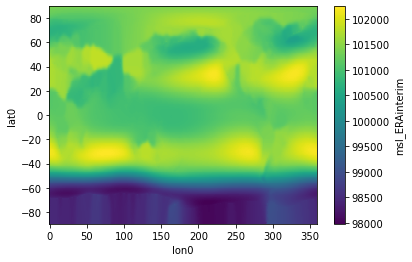

precip


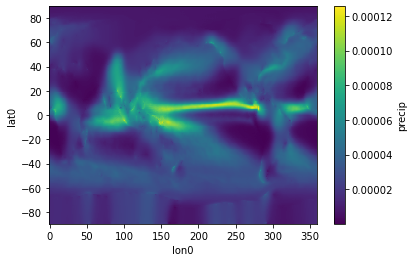

q2


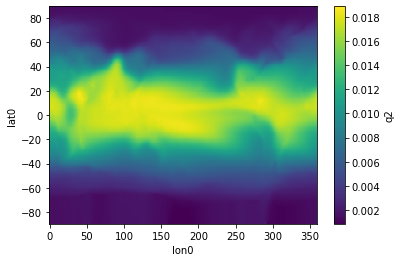

radlw


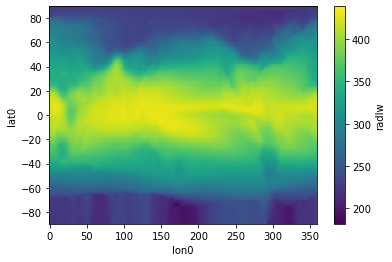

radsw


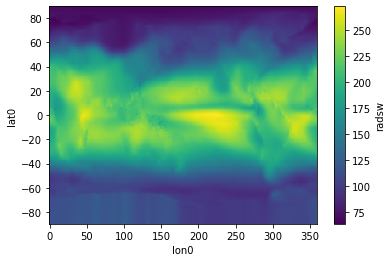

snow


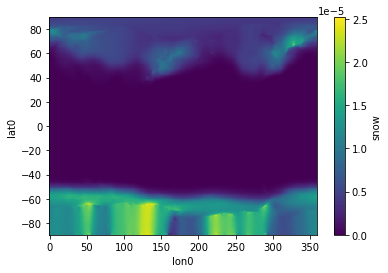

t2


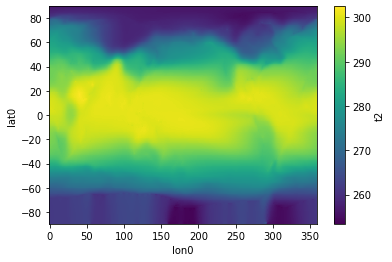

u10


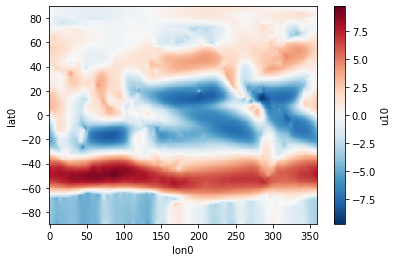

v10


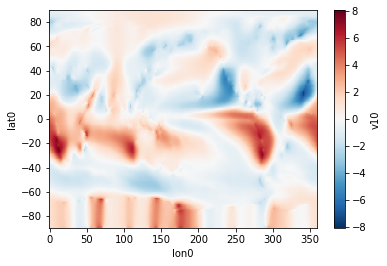

In [8]:
# Quick and dirty plot (NO projection!)
for var in ds.data_vars:
    print(var)
    # Extract DataArray
    da = ds[var]
    # Find dimensions
    timedim = [dim for dim in da.dims if dim.startswith("time")]
    londim = [dim for dim in da.dims if dim.startswith("lon")][0]
    latdim = [dim for dim in da.dims if dim.startswith("lat")][0]
    # Time average
    da = da.mean(timedim)
    # Plot
    da.plot(x=londim, y=latdim)
    plt.show()